# Tutorial 3: How simulations define your predictions
The inverse problem has no unique solution as it is ill-posed. In order to solve it we need to constraint the space of possible solutions. While inverse solutions like minimum-norm estimates have an explicit constraint of minimum-energy, the constraints with esinet are implicit and mostly shaped by the simulations.

This tutorial aims the relation between simulation parameters and predictions.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import mne
# import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
plot_params = dict(surface='white', hemi='both', verbose=0)

## Create Forward model
First we create a template forward model which comes with the esinet package

In [2]:
info = get_info(sfreq=100)
fwd = create_forward_model(sampling="ico3", info=info)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.8s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.8s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


# Simulate

## defs

In [3]:
import numpy as np
import tensorflow as tf
import mne
def prep_data(sim):
    X = np.squeeze(np.stack([eeg.average().data for eeg in sim.eeg_data]))
    X = np.stack([(x - np.mean(x)) / np.std(x) for x in X], axis=0)
    y = np.squeeze(np.stack([src.data for src in sim.source_data]))
    y = np.stack([(x / np.max(abs(x))) for x in y], axis=0)

    X = np.swapaxes(X, 1,2)
    y = np.swapaxes(y, 1,2)
    return X, y

def sparsity(y_true, y_pred):
    return K.mean(K.square(y_pred)) / K.max(K.square(y_pred))
def custom_loss():
    def loss(y_true, y_pred):
        loss1 = tf.keras.losses.CosineSimilarity()(y_true, y_pred)
        loss2 = sparsity(None, y_pred)
        return loss1 + loss2 * 1e-3
    return loss

from esinet.evaluate import auc_metric, eval_auc, eval_nmse, eval_mean_localization_error

def eval(y_true, y_hat):
    n_samples = y_true.shape[0]
    n_time = y_true.shape[1]
    aucs = np.zeros((n_samples, n_time))
    mles = np.zeros((n_samples, n_time))
    nmses = np.zeros((n_samples, n_time))
    for i in range(n_samples):
        for j in range(n_time):
            aucs[i,j] = np.mean(eval_auc(y_true[i,j], y_hat[i,j], pos))
            nmses[i,j] = eval_nmse(y_true[i,j], y_hat[i,j])
            mles[i,j] = eval_mean_localization_error(y_true[i,j], y_hat[i,j], pos)

    return aucs, nmses, mles

def threshold_activation(x):
    return tf.cast(x > 0.5, dtype=tf.float32)

class Compressor:
    ''' Compression using Graph Fourier Transform
    '''
    def __init__(self):
        pass
    def fit(self, fwd, k=600):
        A = mne.spatial_src_adjacency(fwd["src"], verbose=0).toarray()
        D = np.diag(A.sum(axis=0))
        L = D-A
        U, s, V = np.linalg.svd(L)

        self.U = U[:, -k:]
        self.s = s[-k:]
        self.V = V[:, -k:]
        return self
        
    def encode(self, X):
        ''' Encodes a true signal X
        Parameters
        ----------
        X : numpy.ndarray
            True signal
        
        Return
        ------
        X_comp : numpy.ndarray
            Compressed signal
        '''
        X_comp = self.U.T @ X

        return X_comp

    def decode(self, X_comp):
        ''' Decodes a compressed signal X

        Parameters
        ----------
        X : numpy.ndarray
            Compressed signal
        
        Return
        ------
        X_unfold : numpy.ndarray
            Decoded signal
        '''
        X_unfold = self.U @ X_comp
        return X_unfold

## sim

In [14]:
n_samples = 10000
settings = dict(duration_of_trial=0.25, extents=(1,40), number_of_sources=(1,10), target_snr=99999)
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
X, y = prep_data(sim)

Simulating data based on sparse patches.


100%|██████████| 10000/10000 [00:00<00:00, 14903.65it/s]


source data shape:  (1284, 25) (1284, 25)


100%|██████████| 10000/10000 [00:34<00:00, 285.74it/s]


# FC

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, GRU, multiply, Activation
from tensorflow.keras.regularizers import l1
from esinet.losses import nmae_loss
leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, n_dipoles = leadfield.shape
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 128
n_lstm_units = 30
activation_function = "tanh"
batch_size = 32
epochs = 50
dropout = 0.1

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(inputs)
fc2 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC2')(fc1)
fc3 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC3')(fc2)

direct_out = TimeDistributed(Dense(n_dipoles, 
            activation="linear"),
            name='Output')(fc3)


model = tf.keras.Model(inputs=inputs, outputs=direct_out, name='FC')


model.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer="adam")

model.summary()
model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "FC"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, None, 61)]        0         
_________________________________________________________________
FC1 (TimeDistributed)        (None, None, 300)         18600     
_________________________________________________________________
FC2 (TimeDistributed)        (None, None, 300)         90300     
_________________________________________________________________
Output (TimeDistributed)     (None, None, 1284)        386484    
Total params: 495,384
Trainable params: 495,384
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
266/266 [==============================] - 10s 36ms/step - loss: -0.2599 - val_loss: -0.3134
Epoch 2/50
266/266 [==============================] - 10s 36ms/step - loss: -0.3423 - val_loss: -0.3492
Epoch 3/50
266/266 [============================

# ResNet

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, add
from tensorflow.keras.regularizers import l1
from esinet.losses import nmae_loss
leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, n_dipoles = leadfield.shape
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 128
activation_function = "tanh"
batch_size = 32
epochs = 50
dropout = 0.1

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(inputs)

fc2 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC2')(fc1)


added_layer = add([fc1, fc2], name="adder1")


fc3 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC3')(added_layer)

added_layer = add([added_layer, fc3], name="adder2")



direct_out = TimeDistributed(Dense(n_dipoles, 
            activation="linear"),
            name='Output')(added_layer)


model2 = tf.keras.Model(inputs=inputs, outputs=direct_out, name='ResNet')


model2.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer="adam")

model2.summary()
model2.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, None, 61)]   0                                            
__________________________________________________________________________________________________
FC1 (TimeDistributed)           (None, None, 128)    7936        Input[0][0]                      
__________________________________________________________________________________________________
FC2 (TimeDistributed)           (None, None, 128)    16512       FC1[0][0]                        
__________________________________________________________________________________________________
adder1 (Add)                    (None, None, 128)    0           FC1[0][0]                        
                                                                 FC2[0][0]                   

# Eval

In [20]:
import numpy as np
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import sys; sys.path.insert(0, '../../invert/')
from invert.solvers.empirical_bayes import SolverChampagne

solver = SolverChampagne()
solver.make_inverse_operator(fwd)
n_samples = 50
settings = dict(duration_of_trial=0.25, number_of_sources=(1,10), extents=(1,40))
# settings = dict(duration_of_trial=0.25, number_of_sources=5, extents=(1,2))

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
X_test, y_test = prep_data(sim_test)

# models = [model, model2, ]
# aucs = []
# mles = []
# nmses = []
# for net in models:
#     y_hat = net.predict(X_test)
#     auc, nmse, mle = eval(y_test, y_hat)
#     aucs.append( auc )
#     nmses.append( nmse )
#     mles.append( mle )
#     print(f"{net.name}: \n\t{np.nanmedian(aucs[-1])} AUC \n\t{np.nanmedian(mles[-1])} mm \n\t{np.nanmedian(nmses[-1])} nMSE")

# y_hat = np.stack([solver.apply_inverse_operator(epochs.average()).data for epochs in tqdm(sim_test.eeg_data)], axis=0)
# y_hat = np.swapaxes(y_hat, 1, 2)
# auc, nmse, mle = eval(y_test, y_hat)
# aucs.append( auc )
# nmses.append( nmse )
# mles.append( mle )

# models.append(solver)
# print(f"{solver.name}: \n\t{np.nanmedian(aucs[-1])} AUC \n\t{np.nanmedian(mles[-1])} mm \n\t{np.nanmedian(nmses[-1])} nMSE")

idx = 0
n = sim_test.simulation_info["number_of_sources"].values[idx]
print(f"{n} source(s)")

# PLOTTING BRAINS
stc = sim_test.source_data[idx]
stc.plot(**plot_params, brain_kwargs=dict(title="Ground Truth"))

stc_hat = stc.copy()
y_hat = model.predict(X_test)[idx]
stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title=model.name))
r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
print(f"{model.name}: r={r:.2f}")


y_hat = model2.predict(X_test)[idx]
stc_hat = stc.copy()
stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title=model2.name))
r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
print(f"{model2.name}: r={r:.2f}")



evoked = sim_test.eeg_data[idx].average()
stc_hat = solver.apply_inverse_operator(evoked)
stc_hat.plot(**plot_params, brain_kwargs=dict(title=solver.name))
y_hat = stc_hat.data
r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
print(f"{solver.name}: r={r:.2f}")


Simulating data based on sparse patches.


100%|██████████| 50/50 [00:00<00:00, 12427.57it/s]


source data shape:  (1284, 25) (1284, 25)


100%|██████████| 50/50 [00:00<00:00, 277.78it/s]


3 source(s)
FC: r=0.42
ResNet: r=0.43
Champagne: r=-0.00


C:\Users\Lukas\AppData\Local\Temp/ipykernel_4228/3452833000.py:6: RuntimeWarning: Mean of empty slice
  sns.boxplot(data=np.nanmean(aucs,axis=-1).T)
C:\Users\Lukas\AppData\Local\Temp/ipykernel_4228/3452833000.py:12: RuntimeWarning: Mean of empty slice
  sns.boxplot(data=np.nanmean(mles,axis=-1).T)
C:\Users\Lukas\AppData\Local\Temp/ipykernel_4228/3452833000.py:18: RuntimeWarning: Mean of empty slice
  sns.boxplot(data=np.nanmean(nmses,axis=-1).T)


Text(0.5, 1.0, 'NMSE')

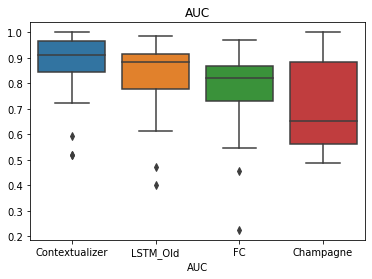

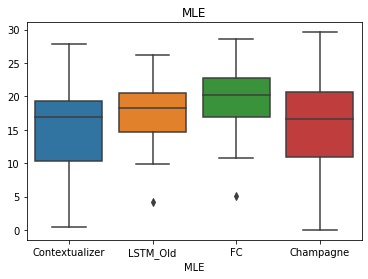

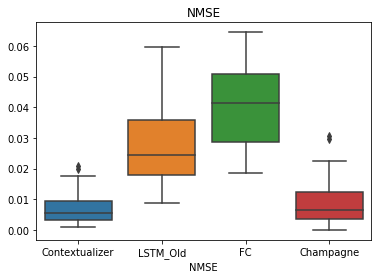

In [50]:
import seaborn as sns
names = [m.name for m in models]
xticks = (np.arange(len(models)), names)

plt.figure()
sns.boxplot(data=np.nanmean(aucs,axis=-1).T)
plt.xticks(*xticks)
plt.xlabel("AUC")
plt.title("AUC")

plt.figure()
sns.boxplot(data=np.nanmean(mles,axis=-1).T)
plt.xticks(*xticks)
plt.xlabel("MLE")
plt.title("MLE")

plt.figure()
sns.boxplot(data=np.nanmean(nmses,axis=-1).T)
plt.xticks(*xticks)
plt.xlabel("NMSE")
plt.title("NMSE")
